<a href="https://colab.research.google.com/github/Ritwiz471/UAP-attack-with-Inception-Resnet/blob/main/UAP_attack_with_InceptionResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/imageData.zip', 'r') 
zip_ref.extractall('/lungData') 
zip_ref.close()

In [ ]:
data_dir = '/lungData/imageData'
classes = os.listdir(data_dir)
print(classes)

['pCT', 'nCT', '.DS_Store']


In [ ]:
batch_size = 8 #number of training examples in a single batch
epochs = 8 #number of epochs
workers = 0 if os.name == 'nt' else 2 #?

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512))) #tranform image

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #define device
print('Running on device: {}'.format(device)) 

Running on device: cuda:0


In [ ]:
resnet = InceptionResnetV1( 
    classify=True, #whether classify into groups or simply recognize faces
    pretrained='vggface2', #the pre-trained model
    num_classes=len(dataset.class_to_idx) #mapping from class to index(label)
).to(device)



In [ ]:
import torch.nn as nn
resnet = nn.Sequential(
    resnet,
    nn.Softmax(1)
)

In [ ]:
child_counter = 0
main_child_cnt=0

for main_child in resnet.children():
  if main_child_cnt==0:
   main_child_cnt+=1
   for child in main_child.children():
    
     if child_counter < 12:
      print("child ",child_counter," was frozen")
      for param in child.parameters():
          param.requires_grad = False
     elif child_counter == 12:
      children_of_child_counter = 0
      for children_of_child in child.children():
         if children_of_child_counter < 1:
           for param in children_of_child.parameters():
	            param.requires_grad = False
           print('child ', children_of_child_counter, 'of child',child_counter,' was frozen')
         else:
           print('child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
         children_of_child_counter += 1
     else:
       print("child ",child_counter," was not frozen")
     child_counter += 1

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was frozen
child  4  was frozen
child  5  was frozen
child  6  was frozen
child  7  was frozen
child  8  was frozen
child  9  was frozen
child  10  was frozen
child  11  was frozen
child  0 of child 12  was frozen
child  1 of child 12  was not frozen
child  2 of child 12  was not frozen
child  13  was not frozen
child  14  was not frozen
child  15  was not frozen
child  16  was not frozen
child  17  was not frozen


In [ ]:
from torchvision.transforms.transforms import Resize
optimizer = optim.Adam(resnet.parameters(), lr=0.001) #Adam optimizer is used as a replacement optimizer for gradient descent and is it is very efficient with large problems which consist of a large number of data
scheduler = MultiStepLR(optimizer, [5, 10]) #decrease the learning rate on reaching specific milestones
 
trans = transforms.Compose([ #transforming into tensor
    np.float32,
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir, transform=trans) #A generic data loader where the images are arranged in this way by default: root/class/xxx.
img_inds = np.arange(len(dataset)) 
np.random.shuffle(img_inds) #shuffling images randomly -> shuffling prevents overfitting and allows generalization
train_inds = img_inds[:int(0.8 * len(img_inds))]  #defining the indices for training and validation sets
val_inds = img_inds[int(0.8 * len(img_inds)):]
#random.split() function -> causing issues

train_loader = DataLoader( #Combines a dataset and a sampler, and provides an iterable over the given dataset.
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds) #this is the splitting function - takes a subset from the mentioned index
) #subset random sampler will divide into balanced datasets if balanced dataset is given as input
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds) 
)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()
#70/30 ratio
#with freezing - 11 min ; without - 23 min
#acc: 99.62% ; 99.2%



Initial
----------
Valid |    21/200  | loss:    0.6931 | fps:   59.2595 | acc:    0.4940   

KeyboardInterrupt: ignored

In [ ]:
import math
import torch
import torch.nn as nn


'''
Basic version of untargeted stochastic gradient descent UAP adapted from:
[AAAI 2020] Universal Adversarial Training
- https://ojs.aaai.org//index.php/AAAI/article/view/6017
Layer maximization attack from:
Universal Adversarial Perturbations to Understand Robustness of Texture vs. Shape-biased Training
- https://arxiv.org/abs/1911.10364
'''
def uap_sgd(model, loader, nb_epoch, eps, beta = 12, step_decay = 0.8, y_target = None):
    '''
    INPUT
    model       model 
    loader      dataloader 
    nb_epoch    number of optimization epochs
    eps         maximum perturbation value (L-infinity) norm
    beta        clamping value
    y_target    target class label for Targeted UAP variation
    
    OUTPUT
    delta.data  adversarial perturbation (delta=3,512,512)
    losses      losses per iteration
    '''
    _, (x_val, y_val) = next(enumerate(loader))     #retrieving the first batch, x_val= (8,3,512,512), y_val= (8,2)
    batch_size = len(x_val)                          #batch_size=8

    batch_delta = torch.zeros_like(x_val)            # batch_delta= (8,3,512,512)
    

    delta = batch_delta[0]          # This will store final perturabtions (delta= 3,512,512)
    losses = []                     # loss function

    loss_fn = nn.CrossEntropyLoss(reduction = 'none') #-yloga-(1-y)log(1-a))

    beta = torch.cuda.FloatTensor([beta]) #converting beta to float

    def clamped_loss(output, target):            
        loss = torch.mean(torch.min(loss_fn(output, target), beta))
        return loss
       
    batch_delta.requires_grad_()

    for epoch in range(nb_epoch):
        print('epoch %i/%i' % (epoch + 1, nb_epoch))
        
        # perturbation step size with decay
        eps_step = eps * step_decay     #eps=CONSTANT, eps_step=learning rate, step_decay gives realtionship between eps and eps_step

        for i, (x_val, y_val) in enumerate(loader):
           
            batch_delta.data = delta.unsqueeze(0).repeat([x_val.shape[0], 1, 1, 1])    #initialising batch_delta to be a repeated stack of 8 deltas

            # for targeted UAP, switch output labels to y_target
            if y_target is not None: y_val = torch.ones(size = y_val.shape, dtype = y_val.dtype) * y_target
            
            perturbed = torch.clamp((x_val + batch_delta).cuda(), 0, 1)

            #CLAMP:
            #torch.clamp() is used to clamp all the elements in an input into the range [min, max]. It takes three parameters: the input tensor, min, and max values. The values less than the min are replaced by the min and the values greater than the max are replaced by the max.

            outputs = model(perturbed)
            
            # loss function value
            loss = clamped_loss(outputs, y_val.cuda())

            if y_target is not None: loss = -loss # minimize loss for targeted UAP
            losses.append(torch.mean(loss))       
            loss.backward()
            
            # batch update
            grad_sign = batch_delta.grad.data.mean(dim = 0).sign()       #finding the gradient with sign. (grad_sign=3,512,512)
            delta = delta + grad_sign * eps_step                         #Updating the perturbation matrix by updating the value by gradients
            delta = torch.clamp(delta, -eps, eps)                        #normalising gradients to make sure they lie between (-eps) and (eps)
            batch_delta.grad.data.zero_()                                #Set gradients to zero after update
    
    
    return delta.data, losses

In [ ]:
import matplotlib.pyplot as plt
nb_epoch = 8
eps = 10 / 255
beta = 12
step_decay = 0.7
uap, losses = uap_sgd(resnet, val_loader, nb_epoch, eps, beta, step_decay)

epoch 1/8
epoch 2/8
epoch 3/8
epoch 4/8
epoch 5/8
epoch 6/8
epoch 7/8
epoch 8/8


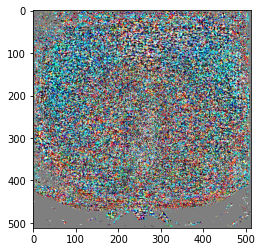

In [ ]:
plt.imshow(np.transpose(((uap / eps) + 1) / 2, (1, 2, 0))) #??


[tensor(0.7033, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6522, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6482, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7083, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6642, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7355, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7484, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6923, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6983, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6266, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7941, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8232, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6617, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7020, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6571, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7500, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6283

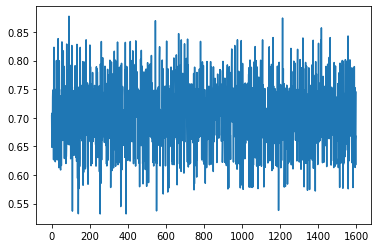

In [ ]:
print(losses)
losses= torch.Tensor(losses)

plt.plot(losses.cpu())


In [ ]:
def show_batch(dl):
    for images in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
import cv2
import torchvision

In [ ]:
def evaluate(model, loader, uap = None, n = 1):
    '''
    OUTPUT
    top         top n predicted labels (default n = 5)
    top_probs   top n probabilities (default n = 5)
    top1acc     array of true/false if true label is in top 1 prediction
    top5acc     array of true/false if true label is in top 5 prediction
    outputs     output labels
    labels      true labels
    '''
    probs, labels = [], []
    model.eval()
    
    if uap is not None:
        _, (x_val, y_val) = next(enumerate(loader))
        batch_size = len(x_val)
        uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1])
    
    with torch.set_grad_enabled(False):
        for i, (x_val, y_val) in enumerate(loader):
            
            if uap is None:
                out = torch.nn.functional.softmax(model(x_val.cuda()), dim = 1)
            else:
                perturbed = torch.clamp((x_val + uap).cuda(), 0, 1) # clamp to [0, 1]
                
                
                out = torch.nn.functional.softmax(model(perturbed), dim = 1)
                
            probs.append(out.cpu().numpy())
            labels.append(y_val)
        
        grid_img = torchvision.utils.make_grid(perturbed.cpu(), nrow=4)
        plt.imshow(grid_img.permute(1, 2, 0))   
    # Convert batches to single numpy arrays    
    probs = np.stack([p for l in probs for p in l])
    labels = np.array([t for l in labels for t in l])
    
    # Extract top 5 predictions for each example
    top = np.argpartition(-probs, n, axis = 1)[:,:n]
    top_probs = probs[np.arange(probs.shape[0])[:, None], top].astype(np.float16)
    outputs = top[range(len(top)), np.argmax(top_probs, axis = 1)]
        
    return outputs, labels

Accuracy: 0.493125
Targeted success rate: 0.9925


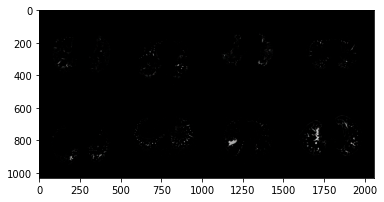

In [ ]:
outputs, labels = evaluate(resnet, val_loader,uap=uap)
print('Accuracy:', sum(outputs == labels) / len(labels))
y_target = 1
print('Targeted success rate:', sum(outputs == y_target) / len(labels))